In [1]:
import pandas as pd
import numpy as np
import pprint as pp
import re, string
import time
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import praw
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction import text 
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import json 
import math
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.dates as mdates

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

# set seaborn settings
sns.set()
plt.rcParams["patch.force_edgecolor"] = True # set lines
plt.style.use('seaborn-darkgrid')


import warnings
warnings.filterwarnings('ignore')

# import credentials and helper functions
import credentials as creds
import helpers as h

C:\Users\Jacky Zhao\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


#### API AND LIBRARY DOCUMENTATIONS:
* https://praw.readthedocs.io/en/latest/
* https://www.reddit.com/wiki/api

## Instantiate Reddit

In [2]:
# pulling my client id and api secret key from my credentials file (not in repository)
# feel free to use your own client id and client secret key
CLIENT_ID = creds.client_id() 
CLIENT_SECRET_KEY = creds.client_secret_key()


r = praw.Reddit(client_id = CLIENT_ID,
                client_secret = CLIENT_SECRET_KEY,
                user_agent = 'RedditorMatch')

Unfortunately, it takes quite some time to retrieve user comments from a particular subreddit. Remember, we're going into a specified subreddit, finding a list of users who posted, and then scraping out every single comment that those users made in the past. In order to remove this bottleneck from my demonstration, I have scraped the comments from users who have posted on r/mizzou. 

If you want to try out other subreddits, I have also scraped r/columbia, r/uofm, and r/chicago. Just replace "mizzou" with any of those subreddits. 

## Recommendation engine logic

In [3]:
def find_similar(matrix, index, top_n = 6):
    cosine_similarities = linear_kernel(matrix[index: index + 1], matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [(index, cosine_similarities[index]) for index in related_docs_indices][0:top_n]

In [4]:
def getDf(subreddit_name):
    # the following scraped files are available for now: mizzou.csv, columbia.csv, umich.csv, and chicago.csv
    filePath = "data/" + subreddit_name + ".csv"
    df = pd.read_csv(filePath, encoding = "ISO-8859-1")
    print("--- Retrieved", len(df), "corpuses for r/", subreddit_name)
    return(df)

In [5]:
def stem(corpus):
    newCorpus = []
    print("------ Stemming the words")
    
    stemmer = PorterStemmer()
    
    for c in corpus:
        try:
            tokens = nltk.word_tokenize(c)
            
            new_tokens = []
            
            for t in tokens:
                try:
                    new_t = stemmer.stem(t)
                    new_tokens.append(new_t)          
                except:
                    print("can't stem the word. moving on...")

            new_c = ' '.join(new_tokens)
            newCorpus.append(new_c)
                
        except:
            print("skipping the comment. something went wrong...")
        
    return(newCorpus)

In [6]:
def createCorpus(your_username, subreddit_name, redditInstance):
    corpus = []    
    corpusDf = getDf(subreddit_name)
    corpusDf["Comments"].apply(lambda row: corpus.append(str(row)))
    
    corpus = stem(corpus)
    
    your_comments = h.getUserComments(your_username, redditInstance)
    your_comments = stem(your_comments)    
    your_comments = " ".join(your_comments)
    
    corpus.insert(0, your_comments)
    return(corpus)

In [7]:
def createTfidfMatrix(corpus):
    myStopWords = stopwords.words('english')
    myStopWords = text.ENGLISH_STOP_WORDS.union(myStopWords)
    
    print("--- Creating Tfidf vectorizor...")
    tf = TfidfVectorizer(analyzer = "word", max_df = 0.8, min_df = 0.2, 
                            ngram_range = (1, 3),
                            stop_words = myStopWords)
    
    print("--- Fitting the matrix...")
    matrix = tf.fit_transform(corpus)
    return(matrix)

In [8]:
def findMatches(your_username, subreddit_name, redditInstance):    
    corpus = createCorpus(your_username, subreddit_name, redditInstance)
    matrix = createTfidfMatrix(corpus)
    corpusDf = getDf(subreddit_name)
    
    results = []
    
    for index, score in find_similar(matrix, 0):        
        index = index - 1 # because we prepended our comments onto the corpus, the index number was shifted by 1.
        user = corpusDf.iloc[index, 0]
        results.append(user)
        print("...")
        print("...")
        print("Username:", user, "| Score:", score)
        print("=========================================================")
        
    return(results)

### Example:

In [9]:
# NOTE: I'm displaying the top 6 usernames who are similar. 
# I chose 6 because if the username is contained in my scraped dataset, 
# then that username will always show up as most similar. 
# But we really only care about the top 5 usernames. 

matches = findMatches("Max_W_", "mizzou", r)

--- Retrieved 288 corpuses for r/ mizzou
------ Stemming the words
------ Retrieved 1872 comments for: Max_W_
------ Stemming the words
--- Creating Tfidf vectorizor...
--- Fitting the matrix...
--- Retrieved 288 corpuses for r/ mizzou
...
...
Username: Max_W_ | Score: 0.988665357434
...
...
Username: BrettGilpin | Score: 0.566912555722
...
...
Username: EveryTrueSon | Score: 0.555348348625
...
...
Username: Apatches | Score: 0.550362479451
...
...
Username: BransonBombshell | Score: 0.55017484834
...
...
Username: SovreignTripod | Score: 0.545611026436


## Gather user information

In [10]:
def getRedditorInfo(redditor_name, r):
    user = r.redditor(redditor_name)
    top = user.comments.top(limit = 1000)
    hot = user.comments.hot(limit = 1000)
    contro = user.comments.controversial(limit = 1000)
    
    subreddit = []
    comment = []
    created_utc = []
    score = []
    ups = []
    downs = []
    controversiality = []
    flair = []
    gilded = []
    over_18 = []
    link = []
    
    for c in top:
        subreddit.append(c.subreddit_name_prefixed)
        comment.append(h.cleanText(c.body))
        
        parsed_date = datetime.utcfromtimestamp(c.created_utc)
        year = parsed_date.year
        month = parsed_date.month
        day = parsed_date.day
        
        created_utc.append(parsed_date)
        score.append(c.score)
        ups.append(c.ups)
        downs.append(c.downs)
        controversiality.append(c.controversiality)
        flair.append(c.author_flair_text)
        gilded.append(c.gilded)
        over_18.append(c.over_18)
        link.append(c.link_permalink)
        
    for c in hot:
        subreddit.append(c.subreddit_name_prefixed)
        comment.append(h.cleanText(c.body))
        
        parsed_date = datetime.utcfromtimestamp(c.created_utc)
        year = parsed_date.year
        month = parsed_date.month
        day = parsed_date.day
        
        created_utc.append(parsed_date)
        score.append(c.score)
        ups.append(c.ups)
        downs.append(c.downs)
        controversiality.append(c.controversiality)
        flair.append(c.author_flair_text)
        gilded.append(c.gilded)
        over_18.append(c.over_18)
        link.append(c.link_permalink)
        
    for c in contro:
        subreddit.append(c.subreddit_name_prefixed)
        comment.append(h.cleanText(c.body))
        
        parsed_date = datetime.utcfromtimestamp(c.created_utc)
        year = parsed_date.year
        month = parsed_date.month
        day = parsed_date.day
        
        created_utc.append(parsed_date)
        score.append(c.score)
        ups.append(c.ups)
        downs.append(c.downs)
        controversiality.append(c.controversiality)
        flair.append(c.author_flair_text)
        gilded.append(c.gilded)
        over_18.append(c.over_18)
        link.append(c.link_permalink)
        
    df = pd.DataFrame(subreddit, columns = ["subreddit"])
    df["comment"] = comment
    df["created_utc"] = created_utc
    df["score"] = score
    df["ups"] = ups
    df["downs"] = downs
    df["controversiality"] = controversiality
    df["flair"] = flair
    df["gilded"] = gilded
    df["over_18"] = over_18
    df["link"] = link
    
    df = df.drop_duplicates(subset = ["comment"], keep = "first")    
    print("Retrieved", len(df), "comments for user:", redditor_name)
    return(df)

### Examples

In [11]:
comments1 = getRedditorInfo("Max_W_", r)
comments2 = getRedditorInfo("BrettGilpin", r)

Retrieved 2413 comments for user: Max_W_
Retrieved 2838 comments for user: BrettGilpin


In [12]:
comments1.head()

,subreddit,comment,created_utc,score,ups,downs,controversiality,flair,gilded,over_18,link
0,r/EnoughTrumpSpam,Can we start a petition to keep them private,2017-05-20 02:22:38,8561,8561,0,0,None,1,False,https://www.reddit.com/r/EnoughTrumpSpam/comme...
1,r/AskReddit,Two down one to go,2018-03-09 05:00:25,5552,5552,0,0,None,0,False,https://www.reddit.com/r/AskReddit/comments/83...
2,r/cringe,Lets applaud her dancers They continued on lik...,2017-01-01 05:24:43,3838,3838,0,0,None,0,False,https://www.reddit.com/r/cringe/comments/5ldm3...
3,r/AskReddit,What do you do when you come across an elephan...,2018-03-09 02:49:12,1969,1969,0,0,None,0,True,https://www.reddit.com/r/AskReddit/comments/83...
4,r/LivestreamFail,She threatened nuclear war with North Korea,2017-11-03 03:50:02,1777,1777,0,0,None,0,False,https://www.reddit.com/r/LivestreamFail/commen...


## Find common subreddits between 2 users

In [13]:
def commonSubreddits(user1, user2, redditInstance):
    
    df1 = getRedditorInfo(user1, redditInstance)
    df2 = getRedditorInfo(user2, redditInstance)
    
    df1 = df1.groupby(["subreddit"])[['comment']]\
                .count().reset_index()\
                .sort_values(["comment"], ascending = False)
            
    df2 = df2.groupby(["subreddit"])[['comment']]\
            .count().reset_index()\
            .sort_values(["comment"], ascending = False)
            
    df1 = df1.merge(df2, on = "subreddit", how = "inner")["subreddit"]
    result = np.array(df1)
    
    return(result)

In [14]:
def commonSubredditCounts(user1, user2, redditInstance):
    
    common = commonSubreddits(user1, user2, redditInstance)  
    print(len(common), "common subreddits found...")
    
    df1 = getRedditorInfo(user1, redditInstance)
    df2 = getRedditorInfo(user2, redditInstance)
    
    df1 = df1[df1["subreddit"].isin(common)]
    df2 = df2[df2["subreddit"].isin(common)]
        
    df1Counts = df1.groupby(["subreddit"])[['comment']]\
                .count().reset_index()\
                .sort_values(["comment"], ascending = False)\
                .reset_index(drop = True)
                
    df2Counts = df2.groupby(["subreddit"])[['comment']]\
            .count().reset_index()\
            .sort_values(["comment"], ascending = False)\
            .reset_index(drop = True)      
            
    renameCols = ["id", "value"]
            
    df1Counts.columns = renameCols
    df2Counts.columns = renameCols
    
    df1Counts["id"] = df1Counts["id"].str.lower()
    df2Counts["id"] = df2Counts["id"].str.lower()
    
    df1Counts["id"] = df1Counts["id"].str.replace("r/", "")
    df2Counts["id"] = df2Counts["id"].str.replace("r/", "")
    
    df1Counts = df1Counts.sort_values(by = ["id"], ascending = True).reset_index()
    df2Counts = df2Counts.sort_values(by = ["id"], ascending = True).reset_index()    
    
                
    return(df1Counts, df2Counts)

In [15]:
def subredditCounts(user, redditInstance):
    df1 = getRedditorInfo(user, redditInstance)
    
    df1Counts = df1.groupby(["subreddit"])[['comment']]\
                .count().reset_index()\
                .sort_values(["comment"], ascending = False)\
                .reset_index(drop = True)
                
    renameCols = ["id", "value"]
    df1Counts.columns = renameCols
    df1Counts["id"] = df1Counts["id"].str.lower()
    df1Counts["id"] = df1Counts["id"].str.replace("r/", "")
    df1Counts = df1Counts.sort_values(by = ["id"], ascending = True)   
    
    return(df1Counts)  

In [16]:
allSubreddits1 = subredditCounts("Max_W_", r)
allSubreddits2 = subredditCounts("PrancingPeach", r)

# Output to CSV files for visualization. 
allSubreddits1.to_csv("frontend/all_sub1.csv", index = False)
allSubreddits2.to_csv("frontend/all_sub2.csv", index = False)

Retrieved 2413 comments for user: Max_W_
Retrieved 2735 comments for user: PrancingPeach


### Examples

In [17]:
one, two = commonSubredditCounts("Max_W_", "BrettGilpin", r)

# Output to CSV files for visualization. 
one.to_csv("frontend/common_sub1.csv", index = False)
two.to_csv("frontend/common_sub2.csv", index = False)

Retrieved 2413 comments for user: Max_W_
Retrieved 2838 comments for user: BrettGilpin
31 common subreddits found...
Retrieved 2413 comments for user: Max_W_
Retrieved 2838 comments for user: BrettGilpin


In [18]:
one.head(20)

,index,id,value
0,7,adviceanimals,30
1,2,android,64
2,30,askmen,1
3,0,askreddit,371
4,21,atheism,2
5,17,aww,5
6,20,baseball,2
7,29,cfb,1
8,4,funny,43
9,9,gifs,22


In [19]:
two.head(20)

,index,id,value
0,19,adviceanimals,8
1,7,android,73
2,1,askmen,151
3,5,askreddit,82
4,29,atheism,1
5,11,aww,39
6,15,baseball,17
7,0,cfb,560
8,27,funny,1
9,26,gifs,1


## Get user flairs

In [20]:
def getFlairs(username, redditInstance):
    df = getRedditorInfo(username, redditInstance)
    flairs = set(np.unique(np.array((df[(df["flair"].isnull() == False) & (df["flair"] != "")]["flair"]))))
    if (len(flairs) < 1):
        print("No flairs for this user")
        return None
    else:
        return(flairs)

In [21]:
getFlairs("Max_W_", r)

Retrieved 2413 comments for user: Max_W_


{'Chiefs',
 'Honor 7X / Asus Nexus 7 / Moto e4+ ',
 'Honor 7X, Blue',
 'Kansas City Royals',
 'MaxW // Force Sensitive',
 'Missouri',
 'Nexus7 FHD',
 'Royals are clutch!'}

In [22]:
getFlairs("BrettGilpin", r)

Retrieved 2838 comments for user: BrettGilpin


{'"The Struggle"',
 '59s',
 'Awesome Sauce',
 'Chiefs',
 'Computer Eng Alumni',
 'FC Kansas City',
 'HTC One M8 - AT&T',
 'Kansas City Royals',
 'Male',
 'Missouri',
 'Missouri Tigers',
 'Missouri Tigers / Dartmouth Big Green',
 'Sporting KC',
 'Sporting Kansas City',
 '♂'}

In [23]:
def getFeatures(your_username, redditInstance):
    
    myStopWords = stopwords.words('english')
    myStopWords = text.ENGLISH_STOP_WORDS.union(myStopWords)
    
    stemmer = PorterStemmer()
    allCorpuses = []
    
    your_comments = h.getUserComments(your_username, redditInstance)
    your_corpus = []
    for yc in your_comments:
        tokens = nltk.word_tokenize(yc)
        new_yc = ' '.join(stemmer.stem(t) for t in tokens)
        your_corpus.append(new_yc)
    
    tf = TfidfVectorizer(analyzer = "word",
                        ngram_range = (1, 3),
                        stop_words = myStopWords) 
    
    matrix = tf.fit_transform(your_corpus)
    features = tf.get_feature_names()
    idf = tf.idf_
    result = dict(zip(features, idf))
    
    return(result)

In [24]:
def getCommonFeatures(user1, user2, redditInstance):
    f1 = getFeatures(user1, redditInstance)
    f2 = getFeatures(user2, redditInstance)
    
    res1 = sorted(((value, key) for (key, value) in f1.items()), reverse = True)[0:5000]
    res2 = sorted(((value, key) for (key, value) in f2.items()), reverse = True)[0:5000]
    
    set1 = set(t[1] for t in res1)
    set2 = set(t[1] for t in res2)
    
    commonFeats = set1 & set2
    return(commonFeats)

In [25]:
getCommonFeatures("Max_W_", "BrettGilpin", r)

------ Retrieved 1872 comments for: Max_W_
------ Retrieved 1958 comments for: BrettGilpin


{'wa easili',
 'wa end',
 'wa entir',
 'wa fake',
 'wa free',
 'wa grab',
 'wa kind',
 'wa later',
 'wa movi',
 'wa nearli',
 'wa nice',
 'wa possibl',
 'wa pretti good',
 'wa reaction',
 'wa rock',
 'wa roll',
 'wa sad',
 'wa taken',
 'wa told',
 'wa worri',
 'wage peopl',
 'wait black',
 'wait dont',
 'want attent',
 'want dont',
 'want hi',
 'want id',
 'want make',
 'want new',
 'want someth',
 'want want',
 'wasnt wa',
 'watch watch',
 'wave',
 'way better',
 'way describ',
 'way veri',
 'weather',
 'wed fuck',
 'wendi',
 'whi doe need',
 'whi everi',
 'whi got',
 'whi need',
 'whi shouldnt',
 'wikipedia articl',
 'willi',
 'win divis',
 'wine',
 'wit',
 'wonder thi',
 'wonder whi',
 'wont let',
 'work att',
 'work fine',
 'work phone',
 'work sometim',
 'worn',
 'wouldnt work',
 'written wa',
 'wrong wa',
 'xda',
 'ye thi',
 'year colleg',
 'year miss',
 'year someon',
 'year thi',
 'yearli',
 'yoga',
 'youd like',
 'youtub didnt',
 'youv gotten',
 'zoom'}

## Find subreddits that a user posts in

In [30]:
def getSubredditsPosted(username, redditInstance):
    comments = getRedditorInfo(username, redditInstance)
    subs = np.array(comments["subreddit"])
    subs = (np.unique(subs))
    return(subs)

In [31]:
getSubredditsPosted("Max_W_", r)

Retrieved 2413 comments for user: Max_W_


array(['r/ActLikeYouBelong', 'r/AdviceAnimals', 'r/AmIFreeToGo',
       'r/Android', 'r/AndroidQuestions', 'r/AnythingGoesPics', 'r/AskMen',
       'r/AskReddit', 'r/BacktotheFuture', 'r/Bad_Cop_No_Donut',
       'r/BannedFromThe_Donald', 'r/BeAmazed', 'r/Blackout2015',
       'r/BravesGIFs', 'r/BuyItForLife', 'r/C25K', 'r/CFB',
       'r/CatsStandingUp', 'r/Celebs', 'r/Chromecast', 'r/Cinemagraphs',
       'r/Cloververse', 'r/ColorizedHistory', 'r/Cyberpunk',
       'r/DC_Cinematic', 'r/DiWHY', 'r/EnoughTrumpSpam',
       'r/ExpectationVsReality', 'r/Eyeshakers', 'r/Fitness', 'r/Frugal',
       'r/Frugal_Jerk', 'r/Fullmoviesonvimeo', 'r/GalGadot',
       'r/GetMotivated', 'r/GradSchool', 'r/HadToHurt',
       'r/HighQualityGifs', 'r/Honor', 'r/Honor8', 'r/Huawei',
       'r/HumansBeingBros', 'r/IAmA', 'r/IDontWorkHereLady',
       'r/IdiotsFightingThings', 'r/IdiotsInCars',
       'r/ImGoingToHellForThis', 'r/Jokes', 'r/JusticePorn', 'r/KCRoyals',
       'r/KansasCityChiefs', 'r/LateS

In [55]:
getSubredditsPosted("BrettGilpin", r)

Retrieved 2838 comments for user: BrettGilpin


array(['r/AbandonedPorn', 'r/AdviceAnimals', 'r/Android', 'r/AskMen',
       'r/AskReddit', 'r/AskWomen', 'r/BeforeNAfterAdoption',
       'r/BoJackHorseman', 'r/CBBBall', 'r/CFB', 'r/CFBOffTopic',
       'r/CFBUploads', 'r/CityPorn', 'r/CollegeBasketball', 'r/FellowKids',
       'r/FiftyFifty', 'r/FreeCompliments', 'r/GirlsMirin', 'r/IAmA',
       'r/ImGoingToHellForThis', 'r/JenniferLawrence', 'r/JusticePorn',
       'r/MLS', 'r/MapPorn', 'r/MicrosoftEdge', 'r/Minecraft',
       'r/MorbidReality', 'r/Motioncitysoundtrack', 'r/Music', 'r/NWSL',
       'r/OutOfTheLoop', 'r/PoliticalDiscussion', 'r/SaintLouisFC',
       'r/SandersForPresident', 'r/ScarlettJohansson', 'r/SimCity',
       'r/SportingKC', 'r/StLouis', 'r/SubredditSimMeta', 'r/Surface',
       'r/TheFulmerCup', 'r/TheStopGirl', 'r/Tinder', 'r/TumblrInAction',
       'r/UniversityofKansas', 'r/WTF', 'r/WatchItForThePlot',
       'r/Windows10', 'r/adventuretime', 'r/apple', 'r/atheism', 'r/aww',
       'r/baseball', 'r/blackb

## Analyze sentiment of user comments

In [32]:
def getSentiment(username, r):
    comments = getRedditorInfo(username, r)
                    
    if (len(comments) < 1):
        print("No comments for that user")
        return None
                        
    comments = comments.sort_values("created_utc", ascending = True)    
    sid = SentimentIntensityAnalyzer()
    
    comments["negative"] = comments["comment"].apply(lambda x: sid.polarity_scores(x)["neg"]) 
    comments["neutral"] = comments["comment"].apply(lambda x: sid.polarity_scores(x)["neu"]) 
    comments["positive"] = comments["comment"].apply(lambda x: sid.polarity_scores(x)["pos"]) 
    comments["compound"] = comments["comment"].apply(lambda x: sid.polarity_scores(x)["compound"]) 
    
    return(comments)    

### Examples

In [33]:
sents = getSentiment("Max_W_", r)
sents.head()

Retrieved 2413 comments for user: Max_W_


,subreddit,comment,created_utc,score,ups,downs,controversiality,flair,gilded,over_18,link,negative,neutral,positive,compound
2419,r/pics,Thats just his pay and doesnt include other bo...,2011-10-06 18:46:47,1,1,0,0,None,0,False,https://www.reddit.com/r/pics/comments/l39co/i...,0.199,0.801,0.000,-0.6894
67,r/AskReddit,I upvoted for karma but I think you already go...,2011-10-14 14:22:20,94,94,0,0,None,0,False,https://www.reddit.com/r/AskReddit/comments/lb...,0.000,1.000,0.000,0.0000
2418,r/pics,Thats odd suddenly at work I got a crick in my...,2011-10-19 18:13:18,1,1,0,0,None,0,False,https://www.reddit.com/r/pics/comments/lhpzc/w...,0.204,0.796,0.000,-0.3182
2417,r/AskReddit,Do yourself a favor and check out BAND OF BROT...,2011-10-24 19:37:39,1,1,0,0,None,0,False,https://www.reddit.com/r/AskReddit/comments/ln...,0.000,0.856,0.144,0.4019
2594,r/mizzou,Seems relevanthttp memegeneratornetcacheinstan...,2011-10-24 21:37:51,3,3,0,0,None,0,False,https://www.reddit.com/r/mizzou/comments/lnigs...,0.000,1.000,0.000,0.0000


## Plot sentiment of comments over time

In [36]:
def plotCumSentiment(username, subreddit_name, redditInstance):
    sents = getSentiment(username, redditInstance)
    subreddit_name = "r/" + subreddit_name
    sents = sents[sents["subreddit"].str.lower() == subreddit_name.lower()]
    sents = sents.sort_values("created_utc", ascending = True)  
    sents = sents.reset_index()
    sents["id"] = sents.index
    sents["cumsentiment"] = sents["compound"].cumsum() 
    
    if (len(sents) < 3):
        print("User has not posted on this subreddit")
        return        
        
    fig, ax = plt.subplots()
    
    _ = ax.plot(sents["created_utc"], sents["cumsentiment"], marker = "", linewidth = 1.9, alpha = 0.9)
    
    title = "Cumulative sentiment score on " + subreddit_name + " for user: " + username
    _ = plt.suptitle(title)
    _ = plt.xticks(rotation=90)
    ax.xaxis.set_major_locator(mdates.YearLocator())    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    _ = plt.show()
    
    return

In [37]:
def plotTopCumSentiments(username, redditInstance):
    sents = getSentiment(username, redditInstance)    
   
    subreddits = np.array(sents.groupby(["subreddit"]).\
                                                  count().\
                                                  reset_index().\
                                                  sort_values("comment", ascending = False).\
                                                  head(4)["subreddit"])
    
    numberOfSubs = len(subreddits)
    
    # create a color palette
    palette = plt.get_cmap('Set1')
    num = 0
    
    for s in subreddits:       
        
        subreddit_name = s
        df = sents[sents["subreddit"].str.lower() == subreddit_name.lower()]       
        
        if (len(df) >= 2):            
            num = num + 1 

            # Find the right spot on the plot
            _ = plt.subplot(2, 2, num)                 

            df = df.sort_values("created_utc", ascending = True)  
            df = df.reset_index()
            df["id"] = df.index
            df["cumsentiment"] = df["compound"].cumsum() 

            _ = plt.plot(df["created_utc"], df["cumsentiment"], marker = "", linewidth = 1.9, alpha = 0.9, color = palette(num))

            # Not ticks everywhere
            if num in range(7) :
                _ = plt.tick_params(labelbottom='off')
            if num not in [1,4,7] :
                _ = plt.tick_params(labelleft='off')

            # Add title
            _ = plt.title(subreddit_name, loc='left', fontsize=12, fontweight=0, color=palette(num))
            _ = plt.xticks(rotation=90)
             

    title = "Cumulative sentiment score " + "for user: " + username
    _ = plt.suptitle(title, fontsize=13, fontweight=0, color='black', style='italic', y=1.02)    
    _ = plt.show()
    
    return

### Examples

Retrieved 2413 comments for user: Max_W_


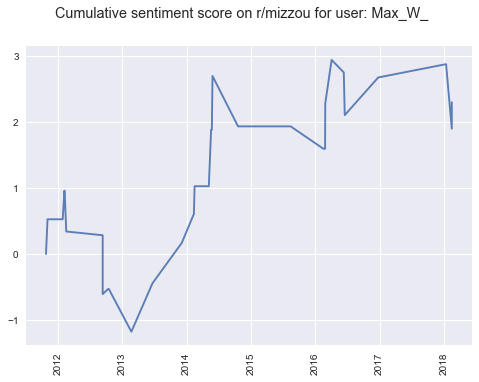

In [38]:
plotCumSentiment("Max_W_", "mizzou", r)

Retrieved 2838 comments for user: BrettGilpin


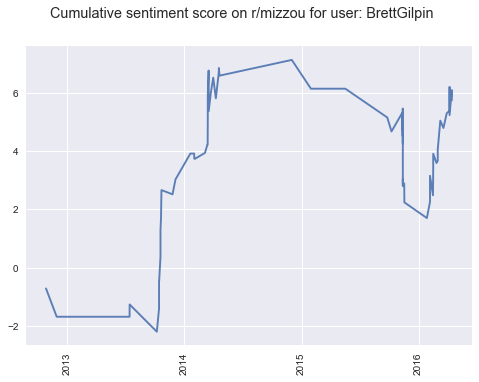

In [39]:
plotCumSentiment("BrettGilpin", "mizzou", r)

Retrieved 2413 comments for user: Max_W_


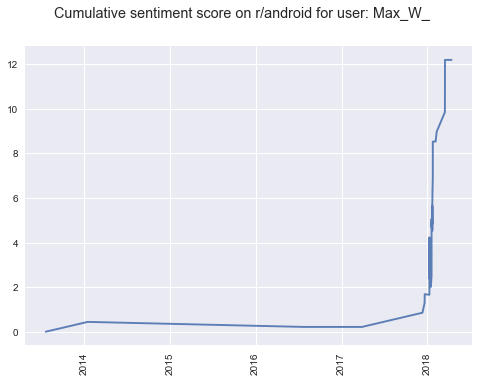

In [40]:
plotCumSentiment("Max_W_", "android", r)

Retrieved 2838 comments for user: BrettGilpin


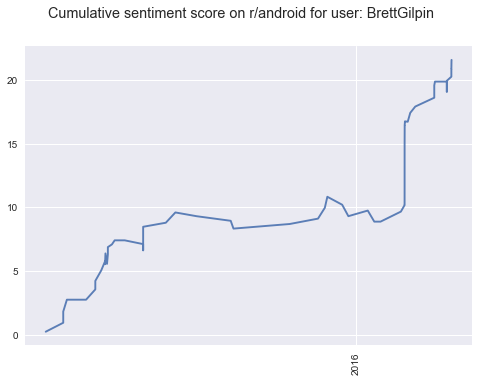

In [41]:
plotCumSentiment("BrettGilpin", "android", r)

Retrieved 2413 comments for user: Max_W_


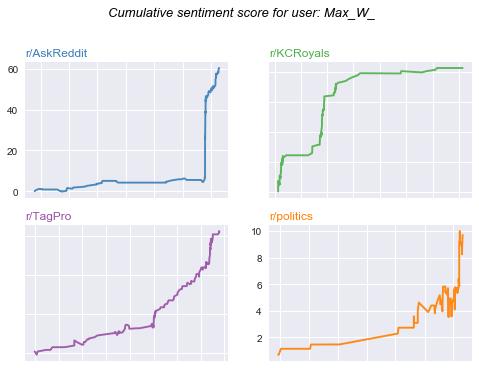

In [42]:
plotTopCumSentiments("Max_W_", r)

Retrieved 2838 comments for user: BrettGilpin


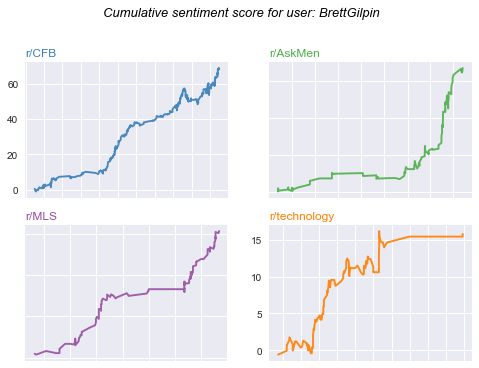

In [43]:
plotTopCumSentiments("BrettGilpin", r)

Retrieved 1510 comments for user: EveryTrueSon


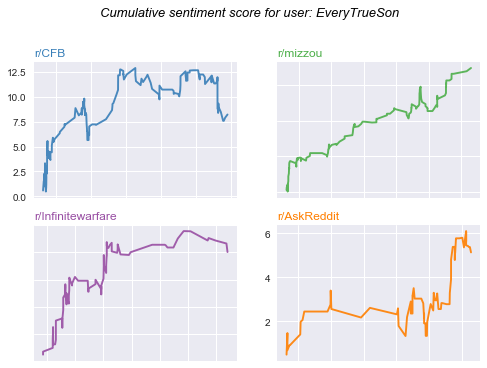

In [44]:
plotTopCumSentiments("EveryTrueSon", r)

Retrieved 1624 comments for user: Apatches


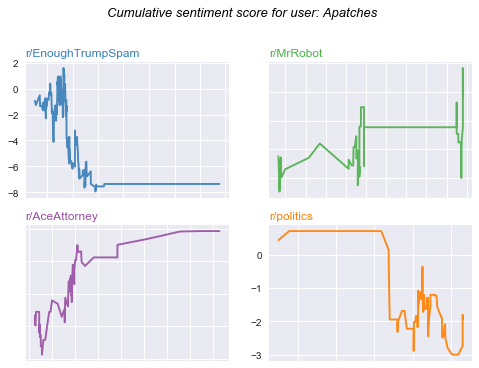

In [45]:
plotTopCumSentiments("Apatches", r)

Retrieved 1987 comments for user: BransonBombshell


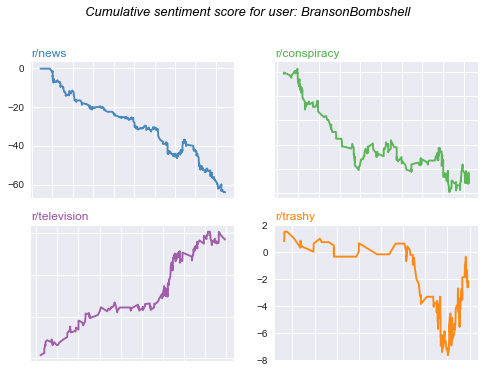

In [46]:
plotTopCumSentiments("BransonBombshell", r)

Retrieved 2054 comments for user: SovreignTripod


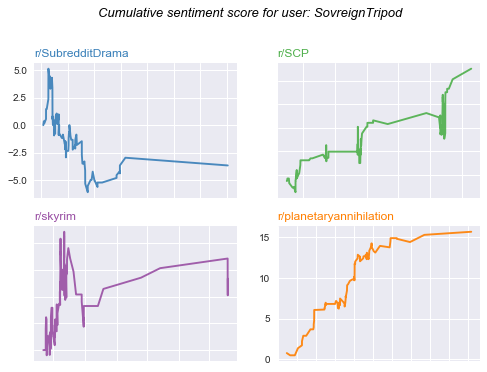

In [47]:
plotTopCumSentiments("SovreignTripod", r)

## Build collapsible index visualization

In [48]:
def formatToDict(name, size):    
    return {'name': name, 'size': round(size*100000)}

In [49]:
def buildCollapsible(your_username, subreddit_name, redditInstance):
    matches = list(findMatches(your_username, subreddit_name, redditInstance))
    
    if (len(matches) < 1): 
        return None
    
    entireObjDict = {}
    entireObjDict["name"] = "Top Features"
    objList = []
    
    for username in matches:
        colNames = ["name", "size"]
        features = getTopFeatures(username, redditInstance)        
        features.columns = colNames
        features = features.head(15)
        
        children = list(features.apply(lambda row: formatToDict(row["name"], row["size"]), axis = 1))
        children
        
        userObj = {}
        userObj["name"] = username
        userObj["children"] = children
        objList.append(userObj)
        
    entireObjDict["children"] = objList        
    return(entireObjDict)        

In [50]:
#jsonObj = buildCollapsible("Max_W_", "mizzou", r)

## Hierarchical document clustering

In [51]:
def buildDendro(your_username, subreddit_name, redditInstance, top_n = 50):
    corpus = createCorpus(your_username, subreddit_name, r)
    corpus = corpus[0:top_n]
    print("Corpus Records:", len(corpus))
    
    matrix = createTfidfMatrix(corpus)
    print("Matrix Shape:", matrix.shape)
    
    dist = 1 - cosine_similarity(matrix)
    print("Distance Shape:", dist.shape)
    
    corpusDf = getDf(subreddit_name)
    corpusDf = corpusDf.head(top_n - 1)
    
    usernames = list(corpusDf["Username"])
    usernames.insert(0, your_username)
    print("Number of usernames:", len(usernames))
    
    for index, score in find_similar(matrix, 0):        
        index = index - 1 # because we prepended our comments onto the corpus, the index number was shifted by 1.
        user = corpusDf.iloc[index, 0]
        print("...")
        print("...")
        print("Username:", user, "| Score:", score)
        print("=========================================================")
          
    linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

    fig, ax = plt.subplots(figsize=(15, 20)) # set size
    ax = dendrogram(linkage_matrix, orientation="right", labels = usernames);

    plt.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')

    plt.tight_layout() #show plot with tight layout

    #uncomment below to save figure
    plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
          
    return(plt)

--- Retrieved 288 corpuses for r/ mizzou
------ Stemming the words
------ Retrieved 1872 comments for: Max_W_
------ Stemming the words
Corpus Records: 20
--- Creating Tfidf vectorizor...
--- Fitting the matrix...
Matrix Shape: (20, 5801)
Distance Shape: (20, 20)
--- Retrieved 288 corpuses for r/ mizzou
Number of usernames: 20
...
...
Username: YouKnowThatOtherGuy | Score: 0.548840139718
...
...
Username: WorseThanHipster | Score: 0.513309679284
...
...
Username: pisspoordecisions | Score: 0.481271077098
...
...
Username: seslor | Score: 0.479250439421
...
...
Username: J_Tuck | Score: 0.443518709856
...
...
Username: sahtopi | Score: 0.384785420125


<module 'matplotlib.pyplot' from 'C:\\Users\\Jacky Zhao\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

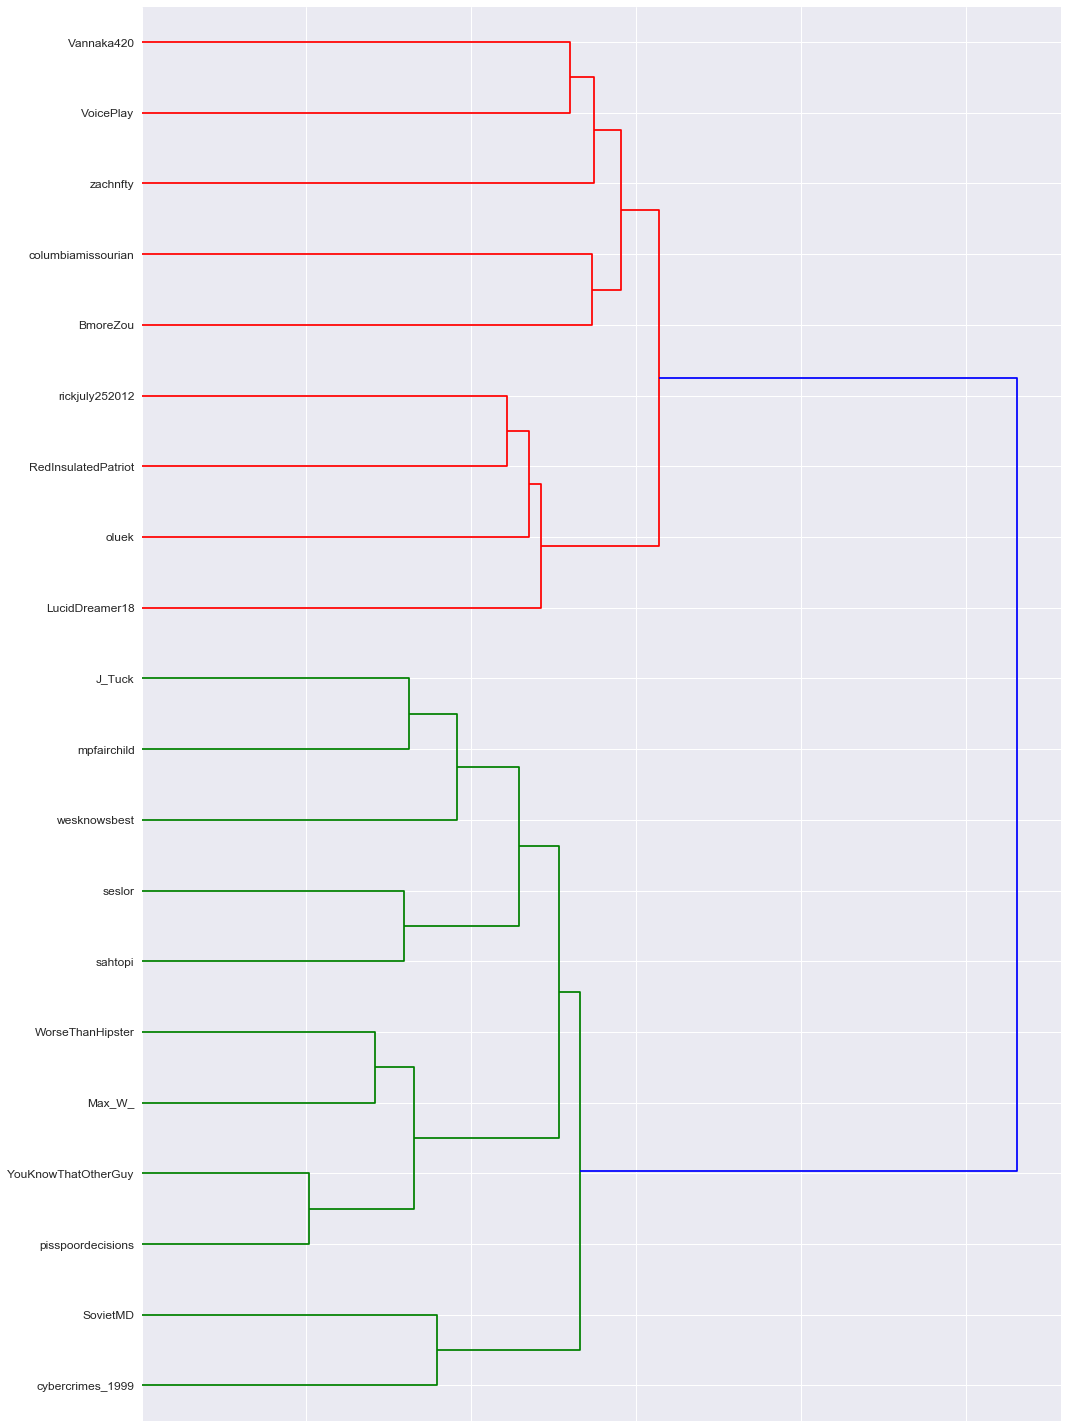

In [52]:
buildDendro("Max_W_", "mizzou", r, 20)